# Quantum Neural Networks

A Quantum Neural Network is built for a 2D CFD problem of determining the lift coefficient for varying angles of attack, $\alpha\in[0,15\degree]$. The tutorial below shows for a single feature (soon to be extended to multiple features).

## Install Necessary Libraries

Depending the environment manager, change the first command word to "mamba"/"conda"/"micromamba" for mamba users, miniconda/anaconda users and micromamba users respectively.

In [ ]:
!conda install pandas scipy scikit-learn -c conda-forge -y

## Import Necessary Libraries

In [1]:
from NoisyCircuits import QuantumCircuit as QC
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import pickle

2025-11-20 17:25:11,645	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Import and Pre-process Data

In [2]:
data = pd.read_csv("design_study_single_feature.csv", header=0)
X = data.iloc[:,0].values.reshape(-1, 1)
Y = data.iloc[:,-1].values.reshape(-1, 1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [4]:
x_train = x_train.flatten()
x_test = x_test.flatten()
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
beta_x = np.linalg.norm(x_train)
beta_y = np.linalg.norm(y_train)
x_train = x_train / beta_x
y_train = y_train / beta_y
x_test = x_test / beta_x
y_test = y_test / beta_y

## Initialize Quantum Circuit Instance with Noise

In [ ]:
token = None # Replace with your IBM Quantum token
backend_name = "ibm_fez"
num_qubits = 3
num_cores = 50
num_trajectories = 50
threshold = 1e-4
jsonize = True
verbose = True
qpu_type = "heron"

Run the code below to get the latest calibration data from IBM hardware

In [ ]:
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()

Run the code below to use a sample noise model from IBM Hardware

In [7]:
if qpu_type == "eagle":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Eagle_QPU.pkl", "rb"))
elif qpu_type == "heron":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb"))
else:
    raise ValueError("Unsupported qpu_type. Supported types are 'eagle' and 'heron'.")

In [8]:
nqc = QC(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores,
         backend_qpu_type="heron", 
         num_trajectories=num_trajectories, 
         threshold=threshold, 
         jsonize=jsonize,
         verbose=verbose)

Completed Extraction of two-qubit gate Errors.
Starting post-processing on Single Qubit Errors.
Completed post-processing on Single Qubit Errors.
Processing two-qubit gate errors.
Qubit pair (0, 1): 18/48 errors above threshold (30 filtered out)
Qubit pair (1, 0): 18/48 errors above threshold (30 filtered out)
Qubit pair (1, 2): 18/48 errors above threshold (30 filtered out)
Qubit pair (2, 1): 18/48 errors above threshold (30 filtered out)
Two Qubit Gate errors processed.
Building Noise Operators for Two Qubit Gate Errors.
Completed building Noise Operators for Two Qubit Gate Errors.
Extracting Measurement Errors.
Available qubits in roerror_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88

## Running the QNN

### Build Quantum Circuit for Quantum Neural Network

Here, the original circuit is modified and the single feature is embedded across $3$ qubits.

In [9]:
def quantum_circuit_pure(weights, x_value):
    # Reset the quantum circuit
    nqc.refresh()
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute the circuit
    probs = nqc.run_pure_state(qubits=range(num_qubits))
    # Obtain the expectation value from the output probability distribution
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

In [10]:
def quantum_circuit_noisy(weights, x_value):
    nqc.refresh()
    total_layers = len(weights) // 3
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute circuit
    probs = nqc.execute(qubits=range(num_qubits), num_trajectories=50)
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

### Define Functions

Next we define the functions for predictions, loss function and accuracy functions

In [ ]:
def predict(circuit_builder:callable,
            x_array:np.ndarray,
            weights:np.ndarray)->np.ndarray:
    predictions = [circuit_builder(weights, x) for x in x_array]
    return np.array(predictions)

def loss_function(circuit_builder:callable,
                  x_array:np.ndarray=x_train,
                  y_array:np.ndarray=y_train,
                  weights:np.ndarray=None)->float:
    predictions = predict(circuit_builder, x_array, weights)
    cost_mse = np.mean((predictions - y_array) ** 2) * beta_y**2
    return cost_mse

def accuracy_function(circuit_builder:callable,
                      x_array:np.ndarray=x_test,
                      y_array:np.ndarray=y_test,
                      weights:np.ndarray=None)->list[float]:
    predictions = predict(circuit_builder, x_array, weights) * beta_y
    rmse = root_mean_squared_error(y_array*beta_y, predictions)
    r2 = r2_score(y_array*beta_y, predictions)
    return [rmse, r2]

[2025-11-20 17:26:27,568 E 183772 184140] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [12]:
def cost_function(circuit_builder:callable,
                  weights_init:np.ndarray,
                  max_iter:int=100)->tuple[np.ndarray, list, list]:
    cost_list = []
    accuracy_list = []

    def objective(weights:np.ndarray,
                circuit_builder:callable)->float:
        global iteration
        loss = loss_function(circuit_builder, weights=weights)
        accuracy = accuracy_function(circuit_builder, weights=weights)
        iteration += 1
        print(f"Epoch: {iteration}\tLoss: {loss}\tRMSE: {accuracy[0]}\tR2: {accuracy[1]}")
        cost_list.append(loss)
        accuracy_list.append(accuracy)
        return loss
    
    opt = minimize(objective, x0=weights_init,
                   args=(circuit_builder,),
                   method="COBYLA", options={"maxiter": max_iter})
    weights = opt.x
    return (weights, cost_list, accuracy_list)

## Run the QNN

In [13]:
max_iter = 100
num_layers = 4
weights_init = np.random.uniform(-2*np.pi, 2*np.pi, size=(num_qubits*num_layers))

### Run the QNN with Pure Statevector Simulation

In [14]:
iteration = 0
weights_pure, cost_list_pure, accuracy_list_pure = cost_function(circuit_builder=quantum_circuit_pure,  
                                                                 weights_init=weights_init, 
                                                                 max_iter=max_iter)

Epoch: 1	Loss: 0.24330240684813034	RMSE: 0.4860556844161802	R2: 0.17056618832044745
Epoch: 2	Loss: 0.8498463699842722	RMSE: 0.9194644417104973	R2: -1.9681070410895143
Epoch: 3	Loss: 0.4223519062985307	RMSE: 0.7639264263228962	R2: -1.0488621977764527
Epoch: 4	Loss: 0.44753354058631534	RMSE: 0.7693960135511333	R2: -1.07830625997671
Epoch: 5	Loss: 0.35419444018639545	RMSE: 0.6203508592830631	R2: -0.35109055637243824
Epoch: 6	Loss: 0.35842431746356307	RMSE: 0.7326975173093687	R2: -0.8847733053899625
Epoch: 7	Loss: 0.08621972894028015	RMSE: 0.38074545921323744	R2: 0.49104527871746473
Epoch: 8	Loss: 0.6933879524697691	RMSE: 0.9077522211889618	R2: -1.8929726155850037
Epoch: 9	Loss: 0.18807922946039946	RMSE: 0.3670017347398192	R2: 0.5271254768843505
Epoch: 10	Loss: 0.3788535257536878	RMSE: 0.5846586527974368	R2: -0.20009173614376752
Epoch: 11	Loss: 0.27808731033129075	RMSE: 0.5963636981602112	R2: -0.248625156622585
Epoch: 12	Loss: 0.17241566929293742	RMSE: 0.5296040111233069	R2: 0.015281235924

### Run the QNN with MCWF Method for Noisy Simulation

In [15]:
iteration = 0
weights_noisy, cost_list_noisy, accuracy_list_noisy = cost_function(circuit_builder=quantum_circuit_noisy,
                                                                    weights_init=weights_init,
                                                                    max_iter=max_iter)

Epoch: 1	Loss: 0.4248351286661356	RMSE: 0.6378913034598582	R2: -0.4285749971448831
Epoch: 2	Loss: 1.0843882684607486	RMSE: 1.035490943198415	R2: -2.764456574685675
Epoch: 3	Loss: 0.2734604009156037	RMSE: 0.6524758785848569	R2: -0.49464689369555903
Epoch: 4	Loss: 1.021999210274578	RMSE: 1.0659455921499135	R2: -2.989144409150085
Epoch: 5	Loss: 1.137208013306292	RMSE: 1.1801496701324132	R2: -3.889718536367983
Epoch: 6	Loss: 0.8721089172338526	RMSE: 1.0940769700372495	R2: -3.2024778677747845
Epoch: 7	Loss: 0.7188330738116866	RMSE: 0.8379556740021276	R2: -1.4651978155164205
Epoch: 8	Loss: 0.5963689567271043	RMSE: 0.7788386100222554	R2: -1.1296323153519703
Epoch: 9	Loss: 0.764317836426752	RMSE: 0.9454523334630276	R2: -2.1382602668324058
Epoch: 10	Loss: 0.2877072396949581	RMSE: 0.6625993680377656	R2: -0.5413870887149257
Epoch: 11	Loss: 1.5221874059914464	RMSE: 1.2956331668179524	R2: -4.893506896576972
Epoch: 12	Loss: 0.26793228746388414	RMSE: 0.5874477236605694	R2: -0.21156894433133577
Epoch:

## Visualize the Results

### Pre-Processing Training and Validation Data

1. Segregate the different metrics for quick and easy visualization.
2. Cap the values of the $R^2$ Score to lie between $[-1,1]$ for clean visualization, where an $R^2$ Score of $-1$. 

In [16]:
accuracy_data_pure = np.array(accuracy_list_pure)
accuracy_data_noisy = np.array(accuracy_list_noisy)
cost_data_pure = np.array(cost_list_pure)
cost_data_noisy = np.array(cost_list_noisy)
rmse_pure = accuracy_data_pure[:,0]
rmse_noisy = accuracy_data_noisy[:,0]
r2_score_pure = accuracy_data_pure[:,1]
r2_score_noisy = accuracy_data_noisy[:,1]
r2_score_pure_filtered = np.clip(r2_score_pure, -1, 1)
r2_score_noisy_filtered = np.clip(r2_score_noisy, -1, 1)
epoch_list = np.arange(1, max_iter+1, 1, dtype=int)

### Visualize the Data

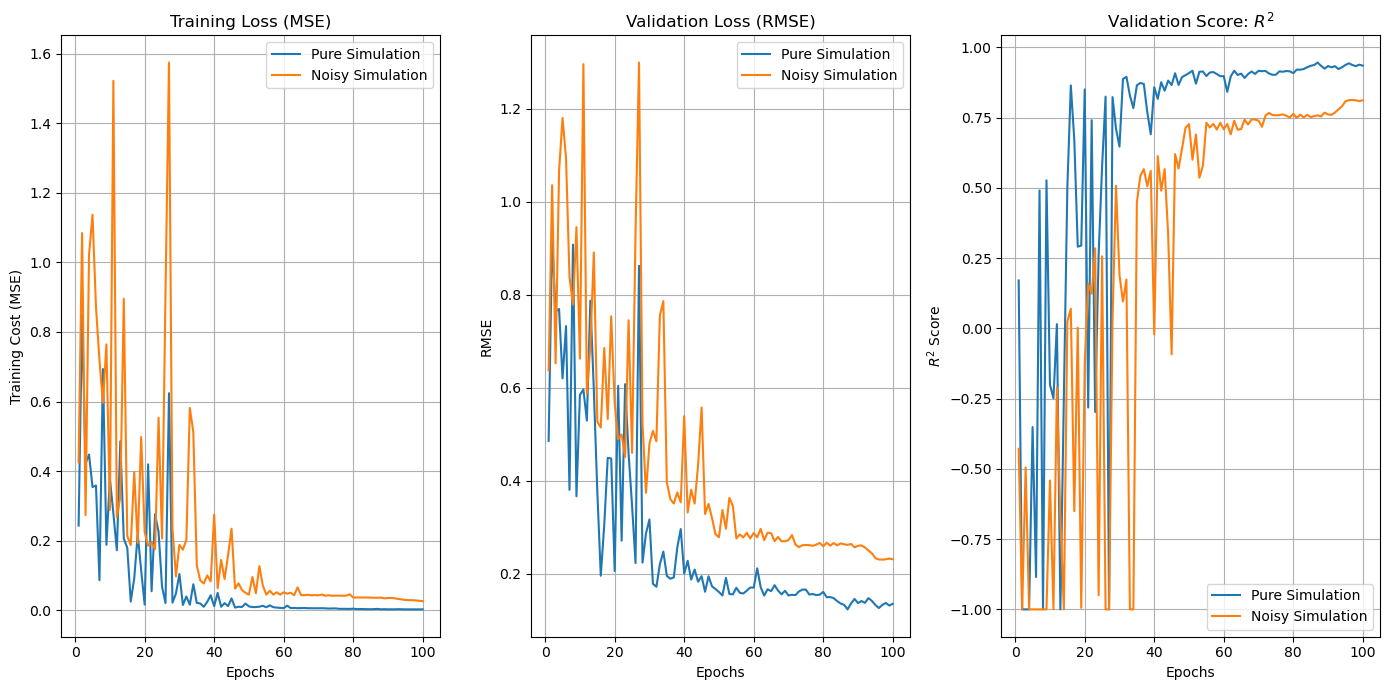

In [17]:
fig, ax = plt.subplots(1,3, figsize=(14,7))
for i, metric in enumerate(zip([cost_data_pure, rmse_pure, r2_score_pure_filtered], [cost_data_noisy, rmse_noisy, r2_score_noisy_filtered])):
    ax[i].plot(epoch_list, metric[0], label="Pure Simulation")
    ax[i].plot(epoch_list, metric[1], label="Noisy Simulation")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(["Training Cost (MSE)", "RMSE", "$R^2$ Score"][i])
    ax[i].set_title(["Training Loss (MSE)", "Validation Loss (RMSE)", "Validation Score: $R^2$"][i])
    ax[i].legend()
    ax[i].grid()
plt.tight_layout()
plt.show()

## Shutdown Parallel Initialization

In [18]:
nqc.shutdown()